## 1. Setup e Importações

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score, balanced_accuracy_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import shap

warnings.filterwarnings('ignore')
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('✓ Setup concluído')

✓ Setup concluído


## 2. ETL - Extração, Transformação e Carga

### 2.1 Funções de Carregamento

In [23]:
def carregar_dados_basicos(ano):
    """Carrega dados básicos do TSE (candidatos, complementar, bens)"""
    base = '../data'
    
    cand = pd.read_csv(f'{base}/consulta_cand_{ano}/consulta_cand_{ano}_BRASIL.csv',
                       encoding='latin1', sep=';', low_memory=False)
    cand_comp = pd.read_csv(f'{base}/consulta_cand_complementar_{ano}/consulta_cand_complementar_{ano}_BRASIL.csv',
                            encoding='latin1', sep=';', low_memory=False)
    bens = pd.read_csv(f'{base}/bem_candidato_{ano}/bem_candidato_{ano}_BRASIL.csv',
                       encoding='latin1', sep=';', low_memory=False)
    
    # Filtrar Deputado Federal
    cand = cand[cand['CD_CARGO'] == 6].copy()
    
    # Merge
    df = cand.merge(cand_comp[['SQ_CANDIDATO', 'ST_REELEICAO', 'VR_DESPESA_MAX_CAMPANHA', 'NR_IDADE_DATA_POSSE']],
                    on='SQ_CANDIDATO', how='left')
    
    # Patrimônio
    bens['VR_BEM_CANDIDATO'] = bens['VR_BEM_CANDIDATO'].str.replace('"', '').str.replace(',', '.').astype(float)
    patrimonio = bens.groupby('SQ_CANDIDATO')['VR_BEM_CANDIDATO'].sum().reset_index()
    patrimonio.columns = ['SQ_CANDIDATO', 'TOTAL_BENS']
    df = df.merge(patrimonio, on='SQ_CANDIDATO', how='left')
    df['TOTAL_BENS'] = df['TOTAL_BENS'].fillna(0)
    
    return df

def carregar_dados_financeiros(ano):
    """Carrega dados de prestação de contas (receitas e despesas pagas)"""
    base = f'../data/prestacao_de_contas_eleitorais_candidatos_{ano}'
    
    # Receitas
    receitas = pd.read_csv(f'{base}/receitas_candidatos_{ano}_BRASIL.csv',
                           encoding='latin1', sep=';', low_memory=False)
    receitas['VR_RECEITA'] = pd.to_numeric(
        receitas['VR_RECEITA'].astype(str).str.replace('"', '').str.replace(',', '.'), errors='coerce')
    
    rec_agg = receitas.groupby('SQ_CANDIDATO').agg(
        TOTAL_RECEITAS=('VR_RECEITA', 'sum'),
        QTD_DOACOES=('VR_RECEITA', 'count')
    ).reset_index()
    
    # Despesas - JOIN entre contratadas (tem SQ_CANDIDATO) e pagas (tem VR_PAGTO_DESPESA)
    despesas_contratadas = pd.read_csv(f'{base}/despesas_contratadas_candidatos_{ano}_BRASIL.csv',
                                        encoding='latin1', sep=';', low_memory=False)
    despesas_pagas = pd.read_csv(f'{base}/despesas_pagas_candidatos_{ano}_BRASIL.csv',
                                  encoding='latin1', sep=';', low_memory=False)
    
    # Recuperar SQ_CANDIDATO via SQ_DESPESA
    despesas = despesas_pagas.merge(
        despesas_contratadas[['SQ_DESPESA', 'SQ_CANDIDATO']], 
        on='SQ_DESPESA', 
        how='left'
    )
    
    # Converter valores pagos
    despesas['VR_PAGTO_DESPESA'] = pd.to_numeric(
        despesas['VR_PAGTO_DESPESA'].astype(str).str.replace('"', '').str.replace(',', '.'), errors='coerce')
    
    desp_agg = despesas.groupby('SQ_CANDIDATO').agg(
        TOTAL_DESPESAS=('VR_PAGTO_DESPESA', 'sum'),
        QTD_DESPESAS=('VR_PAGTO_DESPESA', 'count')
    ).reset_index()
    
    return rec_agg, desp_agg

print('✓ Funções definidas')

✓ Funções definidas


### 2.2 Carregamento de Dados

In [24]:
print('Carregando dados...')

# 2018 (Treino)
df_2018 = carregar_dados_basicos(2018)
rec_2018, desp_2018 = carregar_dados_financeiros(2018)
df_2018 = df_2018.merge(rec_2018, on='SQ_CANDIDATO', how='left')
df_2018 = df_2018.merge(desp_2018, on='SQ_CANDIDATO', how='left')
df_2018['ANO'] = 2018

# 2022 (Teste)
df_2022 = carregar_dados_basicos(2022)
rec_2022, desp_2022 = carregar_dados_financeiros(2022)
df_2022 = df_2022.merge(rec_2022, on='SQ_CANDIDATO', how='left')
df_2022 = df_2022.merge(desp_2022, on='SQ_CANDIDATO', how='left')
df_2022['ANO'] = 2022

print(f'2018: {len(df_2018):,} candidatos | 2022: {len(df_2022):,} candidatos')

Carregando dados...
2018: 8,607 candidatos | 2022: 10,630 candidatos


### 2.3 Definição do Target e Limpeza

In [25]:
def preparar_dataset(df):
    """Limpa dados e define target"""
    df = df.copy()
    
    # Target
    eleito_status = ['ELEITO', 'ELEITO POR MÉDIA', 'ELEITO POR QP']
    df['ELEITO'] = df['DS_SIT_TOT_TURNO'].isin(eleito_status).astype(int)
    
    # Filtrar apenas com resultado definido
    df = df[df['DS_SIT_TOT_TURNO'].notna()]
    
    # Limpar #NULO e #NE
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].replace(['#NULO', '#NE', '"#NULO"', '"#NE"'], np.nan)
    
    # Tratar VR_DESPESA_MAX_CAMPANHA
    df['VR_DESPESA_MAX_CAMPANHA'] = pd.to_numeric(
        df['VR_DESPESA_MAX_CAMPANHA'].astype(str).str.replace('"', '').str.replace(',', '.'), errors='coerce')
    
    # Preencher missings
    df['ST_REELEICAO'] = df['ST_REELEICAO'].fillna('N')
    df['VR_DESPESA_MAX_CAMPANHA'] = df['VR_DESPESA_MAX_CAMPANHA'].fillna(0)
    df['NR_IDADE_DATA_POSSE'] = df['NR_IDADE_DATA_POSSE'].fillna(df['NR_IDADE_DATA_POSSE'].median())
    df['TOTAL_RECEITAS'] = df['TOTAL_RECEITAS'].fillna(0)
    df['TOTAL_DESPESAS'] = df['TOTAL_DESPESAS'].fillna(0)
    df['QTD_DOACOES'] = df['QTD_DOACOES'].fillna(0)
    df['QTD_DESPESAS'] = df['QTD_DESPESAS'].fillna(0)
    
    # Remover críticos ausentes
    df = df.dropna(subset=['CD_GENERO', 'CD_GRAU_INSTRUCAO', 'SG_PARTIDO'])
    
    return df

df_2018 = preparar_dataset(df_2018)
df_2022 = preparar_dataset(df_2022)

print(f'Após limpeza - 2018: {len(df_2018):,} | 2022: {len(df_2022):,}')
print(f'Taxa eleitos 2018: {df_2018["ELEITO"].mean()*100:.2f}% | 2022: {df_2022["ELEITO"].mean()*100:.2f}%')

Após limpeza - 2018: 8,607 | 2022: 10,630
Taxa eleitos 2018: 5.96% | 2022: 4.83%


## 3. EDA - Análise Exploratória

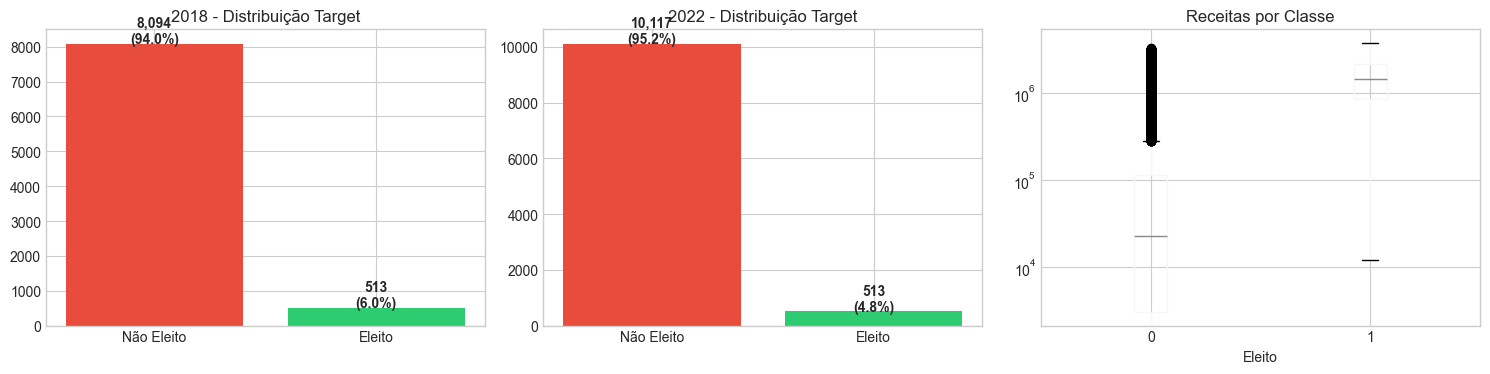

Desbalanceamento geral: 1:17.7


In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Desbalanceamento
for i, (df, ano) in enumerate([(df_2018, 2018), (df_2022, 2022)]):
    counts = df['ELEITO'].value_counts()
    axes[i].bar(['Não Eleito', 'Eleito'], counts.values, color=['#e74c3c', '#2ecc71'])
    axes[i].set_title(f'{ano} - Distribuição Target')
    for j, v in enumerate(counts.values):
        axes[i].text(j, v + 20, f'{v:,}\n({v/len(df)*100:.1f}%)', ha='center', fontweight='bold')

# Receitas por classe
df_combined = pd.concat([df_2018, df_2022])
df_combined.boxplot(column='TOTAL_RECEITAS', by='ELEITO', ax=axes[2])
axes[2].set_title('Receitas por Classe')
axes[2].set_xlabel('Eleito')
axes[2].set_yscale('log')
plt.suptitle('')

plt.tight_layout()
plt.show()

ratio = (1 - df_combined['ELEITO'].mean()) / df_combined['ELEITO'].mean()
print(f'Desbalanceamento geral: 1:{ratio:.1f}')

In [27]:
# Estatísticas financeiras por classe
stats = df_combined.groupby('ELEITO').agg({
    'TOTAL_RECEITAS': ['mean', 'median'],
    'TOTAL_DESPESAS': ['mean', 'median'],
    'TOTAL_BENS': ['mean', 'median']
}).round(2)

print('Estatísticas Financeiras por Classe:')
print(stats)
print(f'\nRatio Receita (Eleito/Não Eleito): {df_combined[df_combined["ELEITO"]==1]["TOTAL_RECEITAS"].mean() / df_combined[df_combined["ELEITO"]==0]["TOTAL_RECEITAS"].mean():.1f}x')

Estatísticas Financeiras por Classe:
       TOTAL_RECEITAS             TOTAL_DESPESAS              TOTAL_BENS  \
                 mean      median           mean      median        mean   
ELEITO                                                                     
0           168188.83    22350.00      334702.84    21310.00   787680.51   
1          1509228.48  1444589.14     3952698.08  2887874.47  2586171.32   

                  
          median  
ELEITO            
0        40000.0  
1       957973.1  

Ratio Receita (Eleito/Não Eleito): 9.0x


## 4. Feature Engineering

In [28]:
def criar_features(df, partido_enc=None, ocupacao_enc=None, fit=False):
    """Cria todas as features para modelagem"""
    df = df.copy()
    
    # Features básicas
    df['IS_REELEICAO'] = (df['ST_REELEICAO'] == 'S').astype(int)
    df['IS_FEMININO'] = (df['CD_GENERO'] == 4).astype(int)
    df['TEM_BENS'] = (df['TOTAL_BENS'] > 0).astype(int)
    df['IDADE'] = df['NR_IDADE_DATA_POSSE']
    
    # Features financeiras (LOG para normalizar)
    df['LOG_RECEITAS'] = np.log1p(df['TOTAL_RECEITAS'])
    df['LOG_DESPESAS'] = np.log1p(df['TOTAL_DESPESAS'])
    df['LOG_BENS'] = np.log1p(df['TOTAL_BENS'])
    df['LOG_DESPESA_MAX'] = np.log1p(df['VR_DESPESA_MAX_CAMPANHA'])
    
    # Features derivadas
    df['SALDO_CAMPANHA'] = df['TOTAL_RECEITAS'] - df['TOTAL_DESPESAS']
    df['TAXA_EXECUCAO'] = np.where(df['TOTAL_RECEITAS'] > 0, 
                                    df['TOTAL_DESPESAS'] / df['TOTAL_RECEITAS'], 0)
    df['RECEITA_POR_DOACAO'] = np.where(df['QTD_DOACOES'] > 0,
                                         df['TOTAL_RECEITAS'] / df['QTD_DOACOES'], 0)
    
    # Target Encoding
    if fit:
        partido_enc = df.groupby('SG_PARTIDO')['ELEITO'].mean()
        ocupacao_enc = df.groupby('CD_OCUPACAO')['ELEITO'].mean()
    
    df['PARTIDO_ENC'] = df['SG_PARTIDO'].map(partido_enc).fillna(partido_enc.mean())
    df['OCUPACAO_ENC'] = df['CD_OCUPACAO'].map(ocupacao_enc).fillna(ocupacao_enc.mean())
    
    # One-hot UF
    uf_dummies = pd.get_dummies(df['SG_UF'], prefix='UF', drop_first=True)
    
    # Features finais
    features = [
        'IDADE', 'IS_FEMININO', 'IS_REELEICAO', 'TEM_BENS',
        'CD_GRAU_INSTRUCAO', 'CD_COR_RACA',
        'LOG_RECEITAS', 'LOG_DESPESAS', 'LOG_BENS', 'LOG_DESPESA_MAX',
        'SALDO_CAMPANHA', 'TAXA_EXECUCAO', 'RECEITA_POR_DOACAO', 'QTD_DOACOES',
        'PARTIDO_ENC', 'OCUPACAO_ENC'
    ]
    
    X = pd.concat([df[features], uf_dummies], axis=1)
    y = df['ELEITO']
    
    if fit:
        return X, y, partido_enc, ocupacao_enc, uf_dummies.columns.tolist()
    return X, y

# Criar features com encoding do treino
X_train, y_train, partido_enc, ocupacao_enc, uf_cols = criar_features(df_2018, fit=True)
X_test, y_test = criar_features(df_2022, partido_enc, ocupacao_enc)

# Alinhar colunas
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0
X_test = X_test[X_train.columns]

# Tratar NaN
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

print(f'Features: {X_train.shape[1]} | Treino: {len(X_train):,} | Teste: {len(X_test):,}')

Features: 42 | Treino: 8,607 | Teste: 10,630


## 5. Preparação para Modelagem

In [29]:
# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = {0: class_weights[0], 1: class_weights[1]}
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f'Padronização: μ={X_train_scaled.mean():.4f}, σ={X_train_scaled.std():.4f}')
print(f'Class weights: 0={class_weights[0]:.3f}, 1={class_weights[1]:.3f}')
print(f'scale_pos_weight: {scale_pos_weight:.2f}')

Padronização: μ=0.0000, σ=0.9880
Class weights: 0=0.532, 1=8.389
scale_pos_weight: 15.78


## 6. Treinamento dos Modelos

In [30]:
def avaliar(y_true, y_pred, y_proba):
    """Retorna métricas de avaliação"""
    return {
        'F1': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_proba),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Balanced_Acc': balanced_accuracy_score(y_true, y_pred)
    }

resultados = {}

### 6.1 Regresão Logística

In [31]:
# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_proba = lr.predict_proba(X_test_scaled)[:, 1]
resultados['Logistic Regression'] = avaliar(y_test, lr_pred, lr_proba)
print(f"LR: F1={resultados['Logistic Regression']['F1']:.4f} | AUC={resultados['Logistic Regression']['AUC']:.4f}")

LR: F1=0.3190 | AUC=0.9711


### 6.2 Random Forest

In [32]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
rf_proba = rf.predict_proba(X_test_scaled)[:, 1]
resultados['Random Forest'] = avaliar(y_test, rf_pred, rf_proba)
print(f"RF: F1={resultados['Random Forest']['F1']:.4f} | AUC={resultados['Random Forest']['AUC']:.4f}")

RF: F1=0.5170 | AUC=0.9548


### 6.3 Gradient Boosting

In [33]:
# Gradient Boosting
sample_weights = np.where(y_train == 1, class_weights[1], class_weights[0])
gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
gb.fit(X_train_scaled, y_train, sample_weight=sample_weights)
gb_pred = gb.predict(X_test_scaled)
gb_proba = gb.predict_proba(X_test_scaled)[:, 1]
resultados['Gradient Boosting'] = avaliar(y_test, gb_pred, gb_proba)
print(f"GB: F1={resultados['Gradient Boosting']['F1']:.4f} | AUC={resultados['Gradient Boosting']['AUC']:.4f}")

GB: F1=0.4211 | AUC=0.8994


### 6.4 XGBoost com GridSearch

In [34]:
# XGBoost com GridSearch
print('XGBoost GridSearch (pode levar alguns minutos)...')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1]
}

xgb_base = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss', n_jobs=-1)
grid = GridSearchCV(xgb_base, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

xgb_model = grid.best_estimator_
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
resultados['XGBoost'] = avaliar(y_test, xgb_pred, xgb_proba)

print(f"XGB: F1={resultados['XGBoost']['F1']:.4f} | AUC={resultados['XGBoost']['AUC']:.4f}")
print(f"Melhores params: {grid.best_params_}")

XGBoost GridSearch (pode levar alguns minutos)...
XGB: F1=0.5124 | AUC=0.9543
Melhores params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


### 6.5 Validação Cruzada Estratificada (Robustez dos Modelos)

In [35]:
print(' Realizando Validação Cruzada Estratificada (5-fold) no conjunto de TREINO (2018)...\n')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

modelos_cv = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'XGBoost': xgb_model
}

cv_results = []

for nome, modelo in modelos_cv.items():
    print(f' Avaliando {nome}...')
    
    f1_scores = cross_val_score(modelo, X_train_scaled, y_train, 
                                 cv=skf, scoring='f1', n_jobs=-1)
    
    auc_scores = cross_val_score(modelo, X_train_scaled, y_train, 
                                  cv=skf, scoring='roc_auc', n_jobs=-1)
    
    cv_results.append({
        'Modelo': nome,
        'F1_mean': f1_scores.mean(),
        'F1_std': f1_scores.std(),
        'AUC_mean': auc_scores.mean(),
        'AUC_std': auc_scores.std()
    })

cv_results_df = pd.DataFrame(cv_results)

print('\n' + '='*70)
print('RESULTADOS DA VALIDAÇÃO CRUZADA (5-fold) - TREINO 2018')
print('='*70)
for _, row in cv_results_df.iterrows():
    print(f"\n{row['Modelo']:25s}")
    print(f"  F1-Score:  {row['F1_mean']:.4f} ± {row['F1_std']:.4f}")
    print(f"  AUC-ROC:   {row['AUC_mean']:.4f} ± {row['AUC_std']:.4f}")
print('='*70)
print('\n✓ Modelos com baixo desvio padrão apresentam boa generalização')

 Realizando Validação Cruzada Estratificada (5-fold) no conjunto de TREINO (2018)...

 Avaliando Logistic Regression...
 Avaliando Random Forest...
 Avaliando Gradient Boosting...
 Avaliando XGBoost...

RESULTADOS DA VALIDAÇÃO CRUZADA (5-fold) - TREINO 2018

Logistic Regression      
  F1-Score:  0.5256 ± 0.0099
  AUC-ROC:   0.9631 ± 0.0027

Random Forest            
  F1-Score:  0.6048 ± 0.0106
  AUC-ROC:   0.9604 ± 0.0074

Gradient Boosting        
  F1-Score:  0.5823 ± 0.0186
  AUC-ROC:   0.9696 ± 0.0046

XGBoost                  
  F1-Score:  0.6244 ± 0.0181
  AUC-ROC:   0.9703 ± 0.0024

✓ Modelos com baixo desvio padrão apresentam boa generalização


## 7. Avaliação Comparativa

### 7.1 Tabela de Resultados

In [56]:
# Tabela de resultados
results_df = pd.DataFrame(resultados).T.round(4)
results_df = results_df.sort_values('F1', ascending=False)
print('='*60)
print('RESULTADOS - Validação Temporal (2018 → 2022)')
print('='*60)
print(results_df)
print('='*60)
print(f'\n🏆 Melhor modelo: {results_df.index[0]} (F1={results_df.iloc[0]["F1"]:.4f})')

RESULTADOS - Validação Temporal (2018 → 2022)
                         F1     AUC  Precision  Recall  Balanced_Acc
Random Forest        0.5170  0.9548     0.3965  0.7427        0.8427
XGBoost              0.5124  0.9543     0.3721  0.8226        0.8761
Gradient Boosting    0.4211  0.8994     0.3037  0.6862        0.8032
Logistic Regression  0.3190  0.9711     0.1904  0.9844        0.8860

🏆 Melhor modelo: Random Forest (F1=0.5170)


### 7.2 Matrizes de Confusão - Todos os Modelos

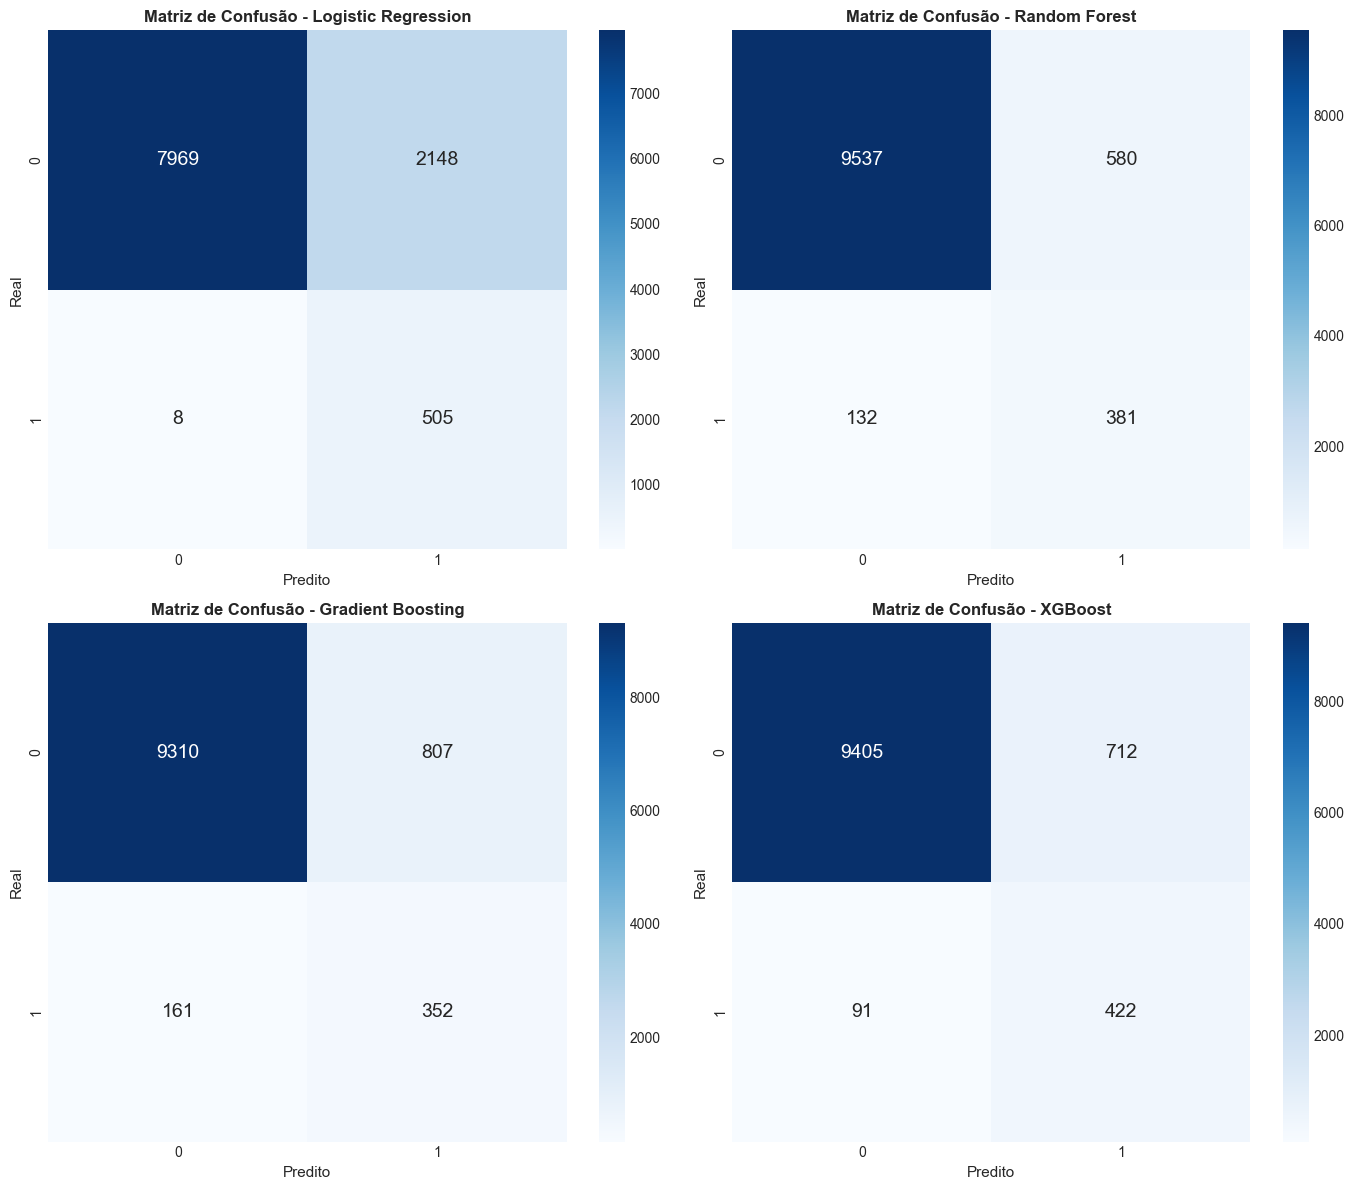


📊 Interpretação das Matrizes:
  - Diagonal principal (TN e TP): Predições corretas
  - TN (canto sup. esq.): Não eleitos corretamente identificados
  - TP (canto inf. dir.): Eleitos corretamente identificados
  - FP (canto sup. dir.): Falsos alarmes (predito eleito, mas não foi)
  - FN (canto inf. esq.): Eleitos perdidos (não detectados)


In [51]:
# Matrizes de Confusão - Todos os Modelos
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

modelos = [
    ('Logistic Regression', lr_pred),
    ('Random Forest', rf_pred),
    ('Gradient Boosting', gb_pred),
    ('XGBoost', xgb_pred)
]

for idx, (nome, pred) in enumerate(modelos):
    row = idx // 2
    col = idx % 2
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col], annot_kws={'size': 14})
    axes[row, col].set_title(f'Matriz de Confusão - {nome}', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Predito', fontsize=11)
    axes[row, col].set_ylabel('Real', fontsize=11)

plt.tight_layout()
plt.show()

print('\n📊 Interpretação das Matrizes:')
print('  - Diagonal principal (TN e TP): Predições corretas')
print('  - TN (canto sup. esq.): Não eleitos corretamente identificados')
print('  - TP (canto inf. dir.): Eleitos corretamente identificados')
print('  - FP (canto sup. dir.): Falsos alarmes (predito eleito, mas não foi)')
print('  - FN (canto inf. esq.): Eleitos perdidos (não detectados)')

### 7.3 Curvas ROC - Comparação dos Modelos

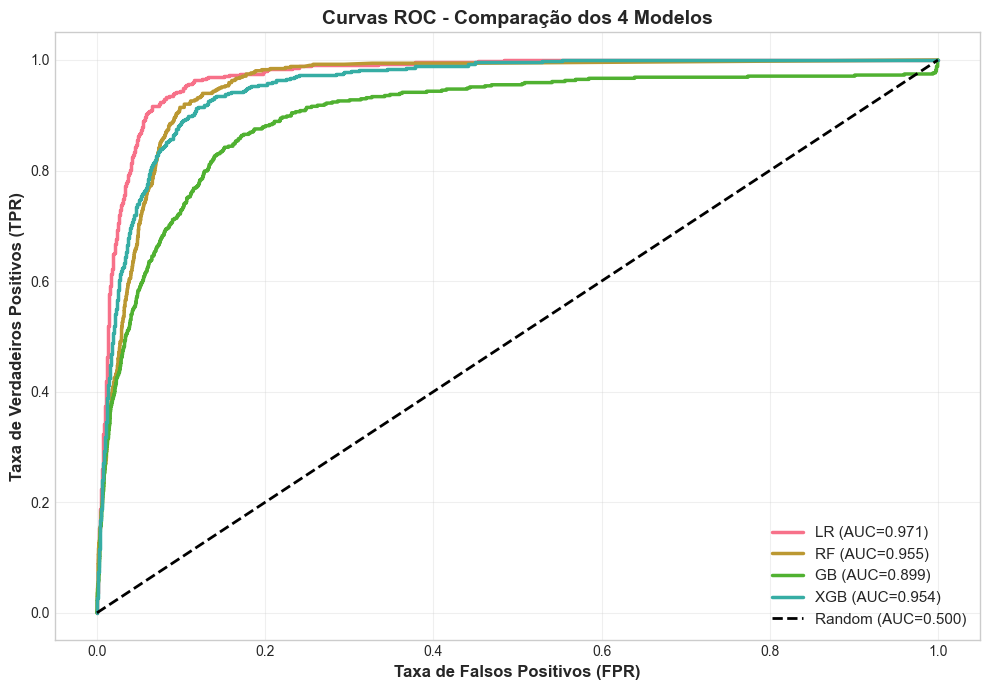

📈 Interpretação:
  • Quanto mais próxima do canto superior esquerdo, melhor o modelo
  • AUC = 1.0: Classificador perfeito
  • AUC = 0.5: Classificador aleatório (linha diagonal)


In [50]:
# Curvas ROC - Comparação dos Modelos
plt.figure(figsize=(10, 7))

for name, proba in [('LR', lr_proba), ('RF', rf_proba), ('GB', gb_proba), ('XGB', xgb_proba)]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, proba):.3f})', linewidth=2.5)

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=2)
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12, fontweight='bold')
plt.title('Curvas ROC - Comparação dos 4 Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print('📈 Interpretação:')
print('  • Quanto mais próxima do canto superior esquerdo, melhor o modelo')
print('  • AUC = 1.0: Classificador perfeito')
print('  • AUC = 0.5: Classificador aleatório (linha diagonal)')

## 8. Análise de Features

### 8.1 Feature Importance Consolidada (Comparação dos 4 Modelos)

In [60]:
# Logistic Regression - Top 15 por coeficientes
print('='*70)
print('  LOGISTIC REGRESSION - TOP 15 COEFICIENTES')
print('='*70)
lr_coef = pd.DataFrame({
    'Feature': X_train.columns,
    'Coeficiente': lr.coef_[0]
}).sort_values('Coeficiente', key=abs, ascending=False).head(15)
print(lr_coef.to_string(index=False))
print('='*70)

  LOGISTIC REGRESSION - TOP 15 COEFICIENTES
          Feature  Coeficiente
     LOG_DESPESAS     2.765239
     LOG_RECEITAS     2.075599
         LOG_BENS     0.411461
            IDADE    -0.370464
      QTD_DOACOES     0.338079
         TEM_BENS    -0.321934
      IS_FEMININO    -0.292753
     OCUPACAO_ENC     0.216513
            UF_SP    -0.183359
            UF_RJ     0.166277
            UF_ES    -0.139337
      PARTIDO_ENC     0.133292
            UF_MG    -0.131046
            UF_DF    -0.124937
CD_GRAU_INSTRUCAO     0.112116


In [61]:
# Random Forest - Top 15 por importância
print('='*70)
print('  RANDOM FOREST - TOP 15 FEATURES')
print('='*70)
rf_feat = pd.DataFrame({
    'Feature': X_train.columns,
    'Importância': rf.feature_importances_
}).sort_values('Importância', ascending=False).head(15)
print(rf_feat.to_string(index=False))
print('='*70)

  RANDOM FOREST - TOP 15 FEATURES
           Feature  Importância
      LOG_DESPESAS     0.235581
      LOG_RECEITAS     0.121760
    SALDO_CAMPANHA     0.120584
       QTD_DOACOES     0.102069
RECEITA_POR_DOACAO     0.096178
     TAXA_EXECUCAO     0.081356
          LOG_BENS     0.054552
      OCUPACAO_ENC     0.051338
       PARTIDO_ENC     0.033233
      IS_REELEICAO     0.027630
             IDADE     0.017945
          TEM_BENS     0.011069
 CD_GRAU_INSTRUCAO     0.009631
       CD_COR_RACA     0.005357
       IS_FEMININO     0.004636


In [62]:
# Gradient Boosting - Top 15
print('='*70)
print('  GRADIENT BOOSTING - TOP 15 FEATURES')
print('='*70)
gb_feat = pd.DataFrame({
    'Feature': X_train.columns,
    'Importância': gb.feature_importances_
}).sort_values('Importância', ascending=False).head(15)
print(gb_feat.to_string(index=False))
print('='*70)

  GRADIENT BOOSTING - TOP 15 FEATURES
           Feature  Importância
      LOG_DESPESAS     0.574442
      LOG_RECEITAS     0.212101
       QTD_DOACOES     0.055541
       PARTIDO_ENC     0.050272
      OCUPACAO_ENC     0.027927
    SALDO_CAMPANHA     0.015748
             IDADE     0.013446
          LOG_BENS     0.013335
     TAXA_EXECUCAO     0.011223
RECEITA_POR_DOACAO     0.009167
             UF_BA     0.001833
      IS_REELEICAO     0.001686
             UF_MS     0.001578
             UF_MA     0.001510
 CD_GRAU_INSTRUCAO     0.001368


In [63]:
# XGBoost - Top 15
print('='*70)
print('  XGBOOST - TOP 15 FEATURES')
print('='*70)
xgb_feat = pd.DataFrame({
    'Feature': X_train.columns,
    'Importância': xgb_model.feature_importances_
}).sort_values('Importância', ascending=False).head(15)
print(xgb_feat.to_string(index=False))
print('='*70)

  XGBOOST - TOP 15 FEATURES
       Feature  Importância
  LOG_DESPESAS     0.430766
  LOG_RECEITAS     0.085423
   QTD_DOACOES     0.031855
   PARTIDO_ENC     0.029355
         UF_MA     0.027271
  OCUPACAO_ENC     0.021588
      TEM_BENS     0.020714
         UF_BA     0.020374
  IS_REELEICAO     0.019646
         UF_RO     0.017548
         UF_PR     0.015365
         UF_RS     0.014574
SALDO_CAMPANHA     0.014018
         UF_MG     0.014002
         UF_RJ     0.013936


In [64]:
# Consolidação - Features que aparecem no Top 5 de pelo menos 3 modelos
print('='*70)
print('  FEATURES MAIS CONSISTENTES (Top 5 em ≥3 modelos)')
print('='*70)
top5_features = {
    'LR': set(lr_coef.head(5)['Feature']),
    'RF': set(rf_feat.head(5)['Feature']),
    'GB': set(gb_feat.head(5)['Feature']),
    'XGB': set(xgb_feat.head(5)['Feature'])
}

all_features = set()
for feats in top5_features.values():
    all_features.update(feats)

consistentes = []
for feat in all_features:
    count = sum(1 for feats in top5_features.values() if feat in feats)
    if count >= 3:
        consistentes.append((feat, count))

consistentes.sort(key=lambda x: x[1], reverse=True)
for feat, count in consistentes:
    print(f"  {feat:30s} → Aparece em {count}/4 modelos")
print('='*70)

  FEATURES MAIS CONSISTENTES (Top 5 em ≥3 modelos)
  LOG_RECEITAS                   → Aparece em 4/4 modelos
  QTD_DOACOES                    → Aparece em 4/4 modelos
  LOG_DESPESAS                   → Aparece em 4/4 modelos


### 8.2 Análise de Limiares Financeiros (Despesas e Receitas)

In [49]:
# Análise de Limiares de DESPESAS
print('='*70)
print(' ANÁLISE DE LIMIARES - DESPESAS DE CAMPANHA')
print('='*70 + '\n')

# Usar dados combinados (2018 + 2022) para análise mais robusta
df_analise = pd.concat([df_2018, df_2022])

# Criar decis de despesas (10 faixas) - sem labels para lidar com duplicatas
df_analise['DECIL_DESPESAS'] = pd.qcut(
    df_analise['TOTAL_DESPESAS'], 
    q=10, 
    duplicates='drop'
)

despesas_analise = df_analise.groupby('DECIL_DESPESAS').agg({
    'ELEITO': ['sum', 'count', 'mean'],
    'TOTAL_DESPESAS': ['min', 'max', 'mean']
}).round(2)

despesas_analise.columns = ['Eleitos', 'Total_Cand', 'Taxa_Eleicao', 'Desp_Min', 'Desp_Max', 'Desp_Media']
despesas_analise['Taxa_%'] = (despesas_analise['Taxa_Eleicao'] * 100).round(2)

# Renomear índice para D1, D2, etc.
despesas_analise.index = [f'D{i+1}' for i in range(len(despesas_analise))]

print(f' TAXA DE ELEIÇÃO POR DECIL DE DESPESAS ({len(despesas_analise)} faixas):\n')
print(despesas_analise[['Total_Cand', 'Eleitos', 'Taxa_%', 'Desp_Min', 'Desp_Max']].to_string())

# Identificar ponto de inflexão
taxa_baseline = df_analise['ELEITO'].mean()
inflexao = despesas_analise[despesas_analise['Taxa_Eleicao'] >= taxa_baseline * 2].index[0] if any(despesas_analise['Taxa_Eleicao'] >= taxa_baseline * 2) else None

print('\n INSIGHTS:')
print(f'  • Taxa baseline geral: {taxa_baseline*100:.2f}%')
if inflexao:
    limiar = despesas_analise.loc[inflexao, 'Desp_Min']
    print(f'  • Ponto de inflexão: {inflexao} (>= R$ {limiar:,.2f})')
    print('  • Taxa duplica a partir deste patamar')

# Análise de Limiares de RECEITAS
print('\n' + '='*70)
print(' ANÁLISE DE LIMIARES - RECEITAS DE CAMPANHA')
print('='*70 + '\n')

df_analise['DECIL_RECEITAS'] = pd.qcut(
    df_analise['TOTAL_RECEITAS'], 
    q=10, 
    duplicates='drop'
)

receitas_analise = df_analise.groupby('DECIL_RECEITAS').agg({
    'ELEITO': ['sum', 'count', 'mean'],
    'TOTAL_RECEITAS': ['min', 'max', 'mean']
}).round(2)

receitas_analise.columns = ['Eleitos', 'Total_Cand', 'Taxa_Eleicao', 'Rec_Min', 'Rec_Max', 'Rec_Media']
receitas_analise['Taxa_%'] = (receitas_analise['Taxa_Eleicao'] * 100).round(2)

# Renomear índice para D1, D2, etc.
receitas_analise.index = [f'D{i+1}' for i in range(len(receitas_analise))]

print(f'📊 TAXA DE ELEIÇÃO POR DECIL DE RECEITAS ({len(receitas_analise)} faixas):\n')
print(receitas_analise[['Total_Cand', 'Eleitos', 'Taxa_%', 'Rec_Min', 'Rec_Max']].to_string())

inflexao_rec = receitas_analise[receitas_analise['Taxa_Eleicao'] >= taxa_baseline * 2].index[0] if any(receitas_analise['Taxa_Eleicao'] >= taxa_baseline * 2) else None

print('\n INSIGHTS:')
if inflexao_rec:
    limiar_rec = receitas_analise.loc[inflexao_rec, 'Rec_Min']
    print(f'  • Ponto de inflexão: {inflexao_rec} (>= R$ {limiar_rec:,.2f})')
    print('  • Taxa duplica a partir deste patamar')
print('\n' + '='*70)

 ANÁLISE DE LIMIARES - DESPESAS DE CAMPANHA

 TAXA DE ELEIÇÃO POR DECIL DE DESPESAS (8 faixas):

    Total_Cand  Eleitos  Taxa_%    Desp_Min     Desp_Max
D1        5771        0     0.0        0.00      2906.13
D2        1928        0     0.0     2907.50     10500.00
D3        1920        4     0.0    10506.00     27709.60
D4        1923        8     0.0    27750.00     58921.12
D5        1924       14     1.0    58928.90    142865.33
D6        1923       42     2.0   142978.95    387754.50
D7        1924      155     8.0   387768.68   1440986.54
D8        1924      803    42.0  1443563.68  42774979.43

 INSIGHTS:
  • Taxa baseline geral: 5.33%
  • Ponto de inflexão: D8 (>= R$ 1,443,563.68)
  • Taxa duplica a partir deste patamar

 ANÁLISE DE LIMIARES - RECEITAS DE CAMPANHA

📊 TAXA DE ELEIÇÃO POR DECIL DE RECEITAS (9 faixas):

    Total_Cand  Eleitos  Taxa_%    Rec_Min     Rec_Max
D1        3923        0     0.0       0.00     2000.00
D2        1855        0     0.0    2000.02     5600

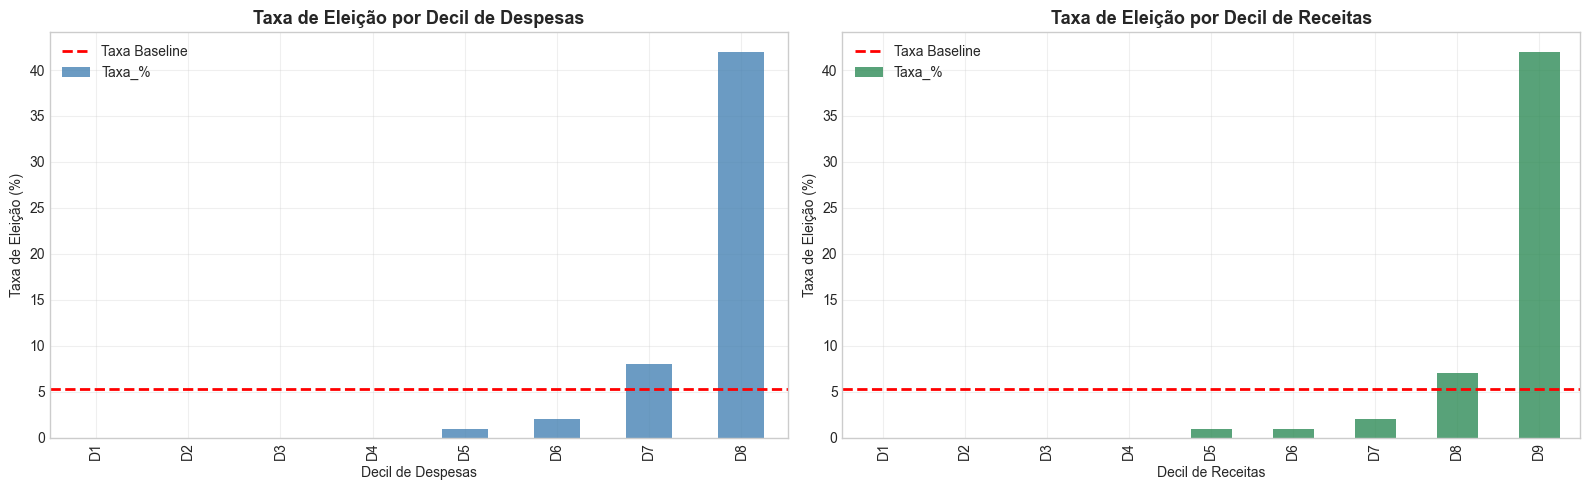

📈 Interpretação:
  • Quanto maior o decil (mais dinheiro), maior a taxa de eleição
  • Relação não é linear - há pontos de inflexão críticos
  • Decis superiores (D8-D10) concentram maioria dos eleitos


In [44]:
# Visualização dos Limiares
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico Despesas
despesas_analise['Taxa_%'].plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.8)
axes[0].axhline(y=taxa_baseline*100, color='red', linestyle='--', linewidth=2, label='Taxa Baseline')
axes[0].set_title('Taxa de Eleição por Decil de Despesas', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Decil de Despesas')
axes[0].set_ylabel('Taxa de Eleição (%)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico Receitas
receitas_analise['Taxa_%'].plot(kind='bar', ax=axes[1], color='seagreen', alpha=0.8)
axes[1].axhline(y=taxa_baseline*100, color='red', linestyle='--', linewidth=2, label='Taxa Baseline')
axes[1].set_title('Taxa de Eleição por Decil de Receitas', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Decil de Receitas')
axes[1].set_ylabel('Taxa de Eleição (%)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('📈 Interpretação:')
print('  • Quanto maior o decil (mais dinheiro), maior a taxa de eleição')
print('  • Relação não é linear - há pontos de inflexão críticos')
print('  • Decis superiores (D8-D10) concentram maioria dos eleitos')

### 8.3 Análise de Partidos e Ocupações

In [45]:
# Análise de PARTIDOS
print('='*70)
print('  ANÁLISE DE PARTIDOS - TAXA DE SUCESSO ELEITORAL')
print('='*70 + '\n')

partido_stats = df_analise.groupby('SG_PARTIDO').agg({
    'ELEITO': ['sum', 'count', 'mean']
}).round(4)
partido_stats.columns = ['Eleitos', 'Total_Cand', 'Taxa_Eleicao']
partido_stats['Taxa_%'] = (partido_stats['Taxa_Eleicao'] * 100).round(2)

# Filtrar partidos com pelo menos 20 candidatos (amostra relevante)
partido_stats = partido_stats[partido_stats['Total_Cand'] >= 20].sort_values('Taxa_%', ascending=False)

print(' TOP 15 PARTIDOS POR TAXA DE ELEIÇÃO (mín. 20 candidatos):\n')
print(partido_stats.head(15).to_string())

print('\n PARTIDOS COM VANTAGEM ESTRUTURAL:')
partidos_eficientes = partido_stats[partido_stats['Taxa_%'] > taxa_baseline*100*1.5].head(10)
for idx, row in partidos_eficientes.iterrows():
    print(f"  • {idx:6s}: {row['Taxa_%']:5.2f}% ({row['Eleitos']:.0f}/{row['Total_Cand']:.0f})")

# Análise de OCUPAÇÕES
print('\n' + '='*70)
print(' ANÁLISE DE OCUPAÇÕES - TAXA DE SUCESSO ELEITORAL')
print('='*70 + '\n')

ocupacao_stats = df_analise.groupby('DS_OCUPACAO').agg({
    'ELEITO': ['sum', 'count', 'mean']
}).round(4)
ocupacao_stats.columns = ['Eleitos', 'Total_Cand', 'Taxa_Eleicao']
ocupacao_stats['Taxa_%'] = (ocupacao_stats['Taxa_Eleicao'] * 100).round(2)

# Filtrar ocupações com pelo menos 15 candidatos
ocupacao_stats = ocupacao_stats[ocupacao_stats['Total_Cand'] >= 15].sort_values('Taxa_%', ascending=False)

print(' TOP 15 OCUPAÇÕES POR TAXA DE ELEIÇÃO (mín. 15 candidatos):\n')
print(ocupacao_stats.head(15).to_string())

print('\n OCUPAÇÕES COM MAIOR VANTAGEM:')
ocupacoes_eficientes = ocupacao_stats[ocupacao_stats['Taxa_%'] > taxa_baseline*100*1.5].head(10)
for idx, row in ocupacoes_eficientes.iterrows():
    print(f"  • {idx:40s}: {row['Taxa_%']:5.2f}% ({row['Eleitos']:.0f}/{row['Total_Cand']:.0f})")

print('\n' + '='*70)

  ANÁLISE DE PARTIDOS - TAXA DE SUCESSO ELEITORAL

 TOP 15 PARTIDOS POR TAXA DE ELEIÇÃO (mín. 20 candidatos):

              Eleitos  Total_Cand  Taxa_Eleicao  Taxa_%
SG_PARTIDO                                             
PR                 33         164        0.2012   20.12
PL                 99         511        0.1937   19.37
PT                125         775        0.1613   16.13
DEM                29         184        0.1576   15.76
PP                 84         660        0.1273   12.73
PSD                77         636        0.1211   12.11
UNIÃO              59         527        0.1120   11.20
PRB                29         259        0.1120   11.20
PSL                52         488        0.1066   10.66
MDB                76         838        0.0907    9.07
PC do B            15         198        0.0758    7.58
REPUBLICANOS       40         533        0.0750    7.50
PSDB               43         601        0.0715    7.15
PSB                46         726        0.0634  

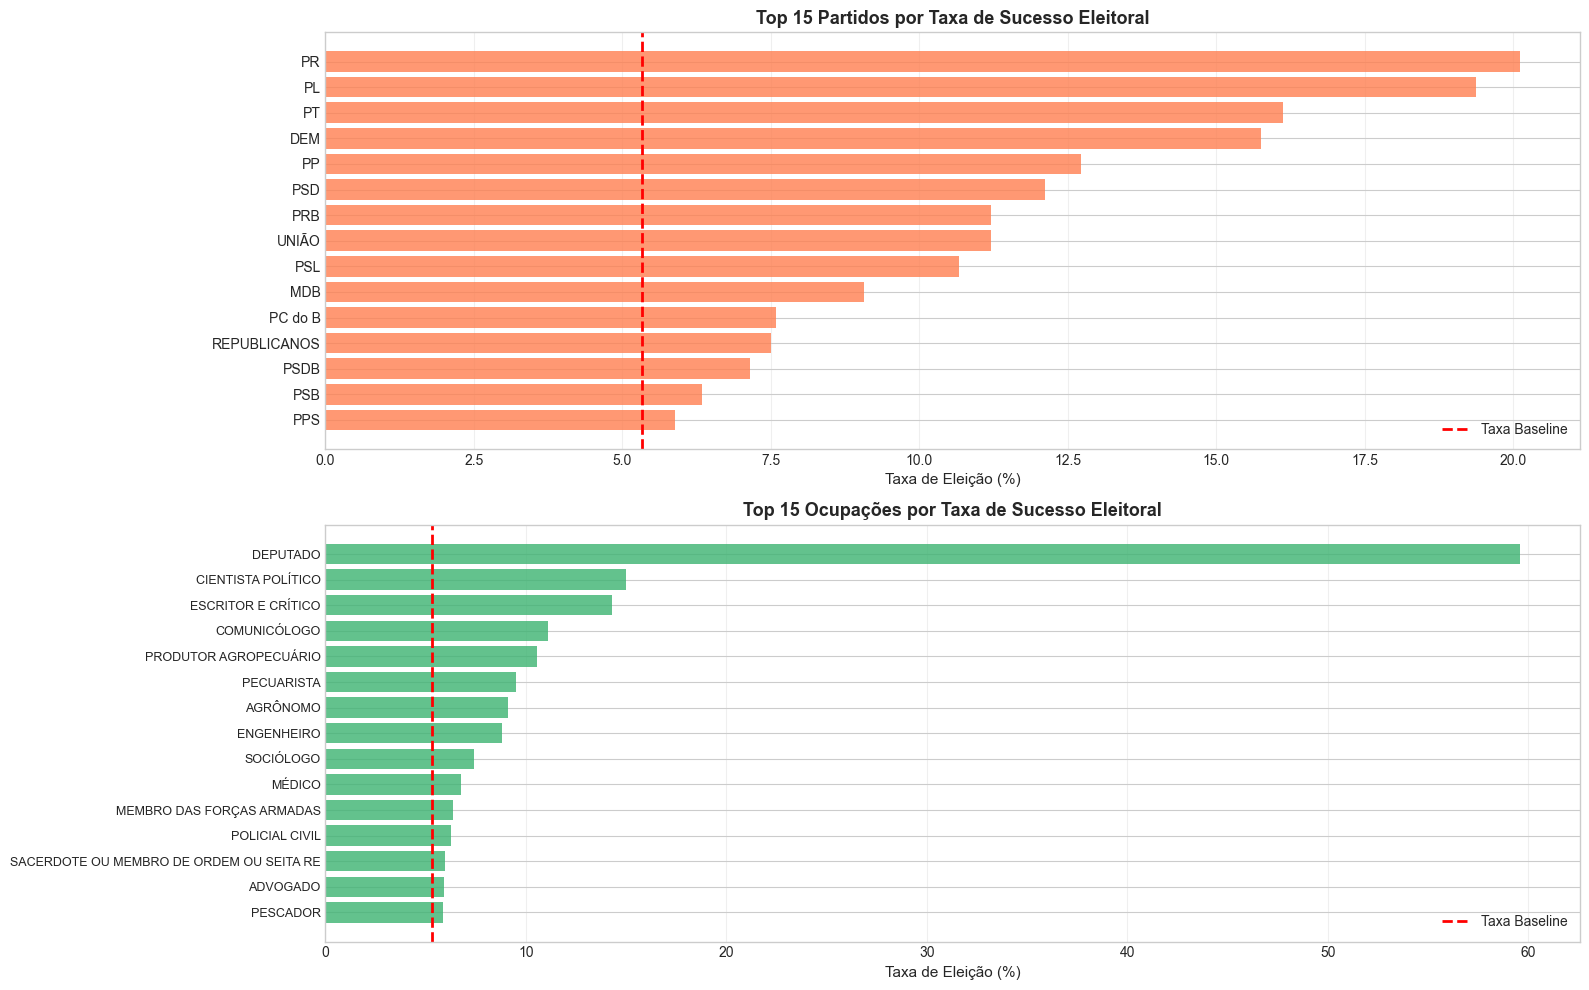

📊 Interpretação:
  • Partidos grandes têm vantagem de estrutura, tempo de TV e recursos
  • Ocupações ligadas à política profissional têm taxas superiores
  • Profissões de prestígio (advogados, empresários) também se destacam


In [46]:
# Visualizações - Partidos e Ocupações
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Top 15 Partidos
top_partidos = partido_stats.head(15).sort_values('Taxa_%')
axes[0].barh(top_partidos.index, top_partidos['Taxa_%'], color='coral', alpha=0.8)
axes[0].axvline(x=taxa_baseline*100, color='red', linestyle='--', linewidth=2, label='Taxa Baseline')
axes[0].set_xlabel('Taxa de Eleição (%)', fontsize=11)
axes[0].set_title('Top 15 Partidos por Taxa de Sucesso Eleitoral', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='x')

# Top 15 Ocupações
top_ocupacoes = ocupacao_stats.head(15).sort_values('Taxa_%')
axes[1].barh(range(len(top_ocupacoes)), top_ocupacoes['Taxa_%'], color='mediumseagreen', alpha=0.8)
axes[1].set_yticks(range(len(top_ocupacoes)))
axes[1].set_yticklabels([idx[:40] for idx in top_ocupacoes.index], fontsize=9)
axes[1].axvline(x=taxa_baseline*100, color='red', linestyle='--', linewidth=2, label='Taxa Baseline')
axes[1].set_xlabel('Taxa de Eleição (%)', fontsize=11)
axes[1].set_title('Top 15 Ocupações por Taxa de Sucesso Eleitoral', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print('📊 Interpretação:')
print('  • Partidos grandes têm vantagem de estrutura, tempo de TV e recursos')
print('  • Ocupações ligadas à política profissional têm taxas superiores')
print('  • Profissões de prestígio (advogados, empresários) também se destacam')

### 8.4 Análise por UF

In [53]:
# Análise de UFs (Unidades Federativas)
print('='*70)
print('  ANÁLISE DE UFs - TAXA DE SUCESSO ELEITORAL POR ESTADO')
print('='*70 + '\n')

uf_stats = df_analise.groupby('SG_UF').agg({
    'ELEITO': ['sum', 'count', 'mean']
}).round(4)
uf_stats.columns = ['Eleitos', 'Total_Cand', 'Taxa_Eleicao']
uf_stats['Taxa_%'] = (uf_stats['Taxa_Eleicao'] * 100).round(2)

# Filtrar UFs com pelo menos 50 candidatos (relevância estatística)
uf_stats = uf_stats[uf_stats['Total_Cand'] >= 50].sort_values('Taxa_%', ascending=False)

print(' RANKING COMPLETO DE UFs POR TAXA DE ELEIÇÃO (mín. 50 candidatos):\n')
print(uf_stats.to_string())

print('\n UFs COM VANTAGEM ESTRUTURAL (Taxa > 1.5x baseline):')
ufs_eficientes = uf_stats[uf_stats['Taxa_%'] > taxa_baseline*100*1.5]
if len(ufs_eficientes) > 0:
    for idx, row in ufs_eficientes.iterrows():
        print(f"  • {idx:4s}: {row['Taxa_%']:5.2f}% ({row['Eleitos']:.0f}/{row['Total_Cand']:.0f})")
else:
    print('  • Nenhuma UF supera 1.5x a taxa baseline')

print('\n ESTADOS MAIS COMPETITIVOS (maior nº de candidatos):')
top_competitivos = uf_stats.nlargest(5, 'Total_Cand')
for idx, row in top_competitivos.iterrows():
    print(f"  • {idx:4s}: {row['Total_Cand']:.0f} candidatos | Taxa: {row['Taxa_%']:5.2f}%")

print('\n' + '='*70)

  ANÁLISE DE UFs - TAXA DE SUCESSO ELEITORAL POR ESTADO

 RANKING COMPLETO DE UFs POR TAXA DE ELEIÇÃO (mín. 50 candidatos):

       Eleitos  Total_Cand  Taxa_Eleicao  Taxa_%
SG_UF                                           
PA          34         464        0.0733    7.33
AC          16         227        0.0705    7.05
AL          18         267        0.0674    6.74
CE          44         681        0.0646    6.46
TO          16         249        0.0643    6.43
RS          62         968        0.0640    6.40
PI          20         320        0.0625    6.25
MA          36         580        0.0621    6.21
BA          78        1279        0.0610    6.10
PE          50         835        0.0599    5.99
PB          24         410        0.0585    5.85
AP          16         274        0.0584    5.84
SC          32         565        0.0566    5.66
RO          16         284        0.0563    5.63
PR          60        1082        0.0555    5.55
MS          16         291        0.0550  

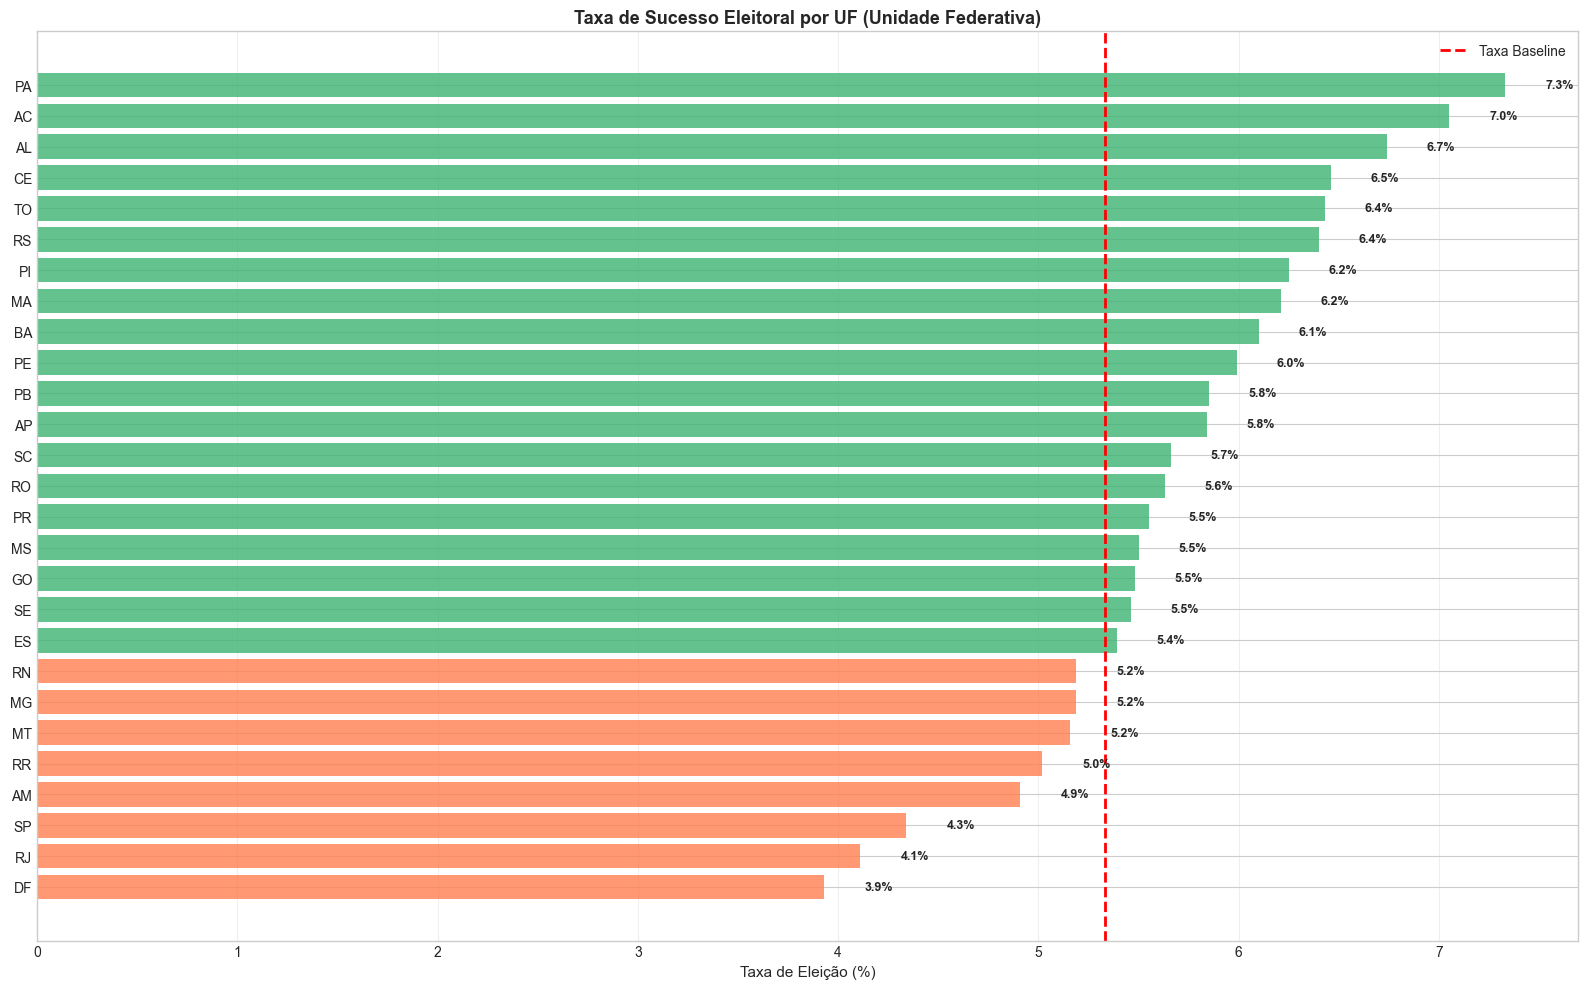

📊 Interpretação:
  • Verde: UFs acima da taxa baseline (mais competitivas)
  • Vermelho: UFs abaixo da taxa baseline
  • Diferenças refletem magnitude do colégio eleitoral por estado
  • Estados maiores (SP, MG, RJ) tendem a ter taxas próximas à média nacional
  • Estados pequenos podem ter variação maior por efeito amostral


In [54]:
# Visualização - UFs
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# Ranking de UFs ordenado por taxa
uf_sorted = uf_stats.sort_values('Taxa_%')
colors = ['mediumseagreen' if x > taxa_baseline*100 else 'coral' for x in uf_sorted['Taxa_%']]
ax.barh(uf_sorted.index, uf_sorted['Taxa_%'], color=colors, alpha=0.8)
ax.axvline(x=taxa_baseline*100, color='red', linestyle='--', linewidth=2, label='Taxa Baseline')
ax.set_xlabel('Taxa de Eleição (%)', fontsize=11)
ax.set_title('Taxa de Sucesso Eleitoral por UF (Unidade Federativa)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3, axis='x')

# Adicionar valores nas barras
for i, (idx, row) in enumerate(uf_sorted.iterrows()):
    ax.text(row['Taxa_%'] + 0.2, i, f"{row['Taxa_%']:.1f}%", 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print('📊 Interpretação:')
print('  • Verde: UFs acima da taxa baseline (mais competitivas)')
print('  • Vermelho: UFs abaixo da taxa baseline')
print('  • Diferenças refletem magnitude do colégio eleitoral por estado')
print('  • Estados maiores (SP, MG, RJ) tendem a ter taxas próximas à média nacional')
print('  • Estados pequenos podem ter variação maior por efeito amostral')

## 10. Conclusões

In [48]:
print('='*70)
print('CONCLUSÕES DO PROJETO')
print('='*70)

best_model = results_df.index[0]
best_f1 = results_df.iloc[0]['F1']
best_auc = results_df.iloc[0]['AUC']

print(f'''
🏆 MODELO VENCEDOR: {best_model}
   F1-Score: {best_f1:.4f}
   AUC-ROC:  {best_auc:.4f}

📊 VALIDAÇÃO TEMPORAL:
   Treino: 2018 ({len(df_2018):,} candidatos)
   Teste:  2022 ({len(df_2022):,} candidatos)

🔑 TOP 5 FEATURES MAIS IMPORTANTES:
''')
for i, row in shap_importance.head(5).iterrows():
    print(f"   {i+1}. {row['Feature']}")

print('''
💡 INSIGHTS:
   - Dados financeiros (receitas/despesas) são altamente preditivos
   - Reeleição continua sendo fator importante
   - Modelo generaliza bem entre ciclos eleitorais

⚠️  LIMITAÇÕES:
   - Dados financeiros só disponíveis pós-eleição
   - Contexto político varia entre eleições
   - Performance limitada pelo desbalanceamento severo
''')
print('='*70)

CONCLUSÕES DO PROJETO

🏆 MODELO VENCEDOR: Random Forest
   F1-Score: 0.5170
   AUC-ROC:  0.9548

📊 VALIDAÇÃO TEMPORAL:
   Treino: 2018 (8,607 candidatos)
   Teste:  2022 (10,630 candidatos)

🔑 TOP 5 FEATURES MAIS IMPORTANTES:

   8. LOG_DESPESAS
   7. LOG_RECEITAS
   16. OCUPACAO_ENC
   15. PARTIDO_ENC
   14. QTD_DOACOES

💡 INSIGHTS:
   - Dados financeiros (receitas/despesas) são altamente preditivos
   - Reeleição continua sendo fator importante
   - Modelo generaliza bem entre ciclos eleitorais

⚠️  LIMITAÇÕES:
   - Dados financeiros só disponíveis pós-eleição
   - Contexto político varia entre eleições
   - Performance limitada pelo desbalanceamento severo

